In [13]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import wget
import csv


2.3.0


In [14]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [15]:
wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv','sunspot.csv')

100% [..............................................................................] 70827 / 70827

'sunspot (2).csv'

In [16]:
time_step = []
sunspots = []

In [17]:
with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))





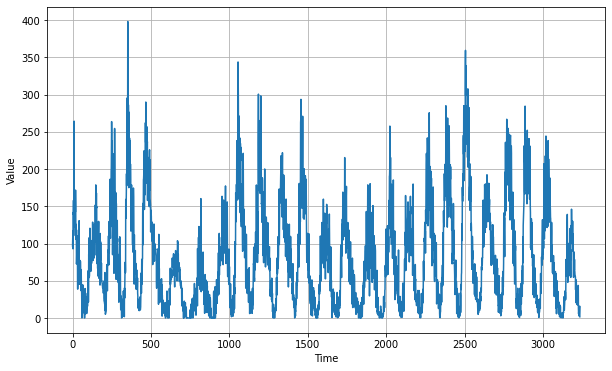

In [18]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])



In [24]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 1s 121ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 1s 116ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 1s 120ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 1s 110ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 1s 109ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 1s 107ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 1s 106ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 1s 107ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 1s 108ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 1s 106ms/step - loss: 52.3436 - mae: 52.8399
Epoch 11/100
12/12 

12/12 [==============================] - 1s 112ms/step - loss: 23.3843 - mae: 23.8783
Epoch 84/100
12/12 [==============================] - 1s 108ms/step - loss: 35.9742 - mae: 36.4706
Epoch 85/100
12/12 [==============================] - 1s 111ms/step - loss: 37.6153 - mae: 38.1116
Epoch 86/100
12/12 [==============================] - 1s 113ms/step - loss: 36.9572 - mae: 37.4535
Epoch 87/100
12/12 [==============================] - 1s 112ms/step - loss: 32.1238 - mae: 32.6198
Epoch 88/100
12/12 [==============================] - 1s 108ms/step - loss: 30.0151 - mae: 30.5099
Epoch 89/100
12/12 [==============================] - 1s 107ms/step - loss: 30.8395 - mae: 31.3352
Epoch 90/100
12/12 [==============================] - 1s 108ms/step - loss: 41.4197 - mae: 41.9170
Epoch 91/100
12/12 [==============================] - 1s 108ms/step - loss: 50.4537 - mae: 50.9513
Epoch 92/100
12/12 [==============================] - 1s 108ms/step - loss: 52.1398 - mae: 52.6380
Epoch 93/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

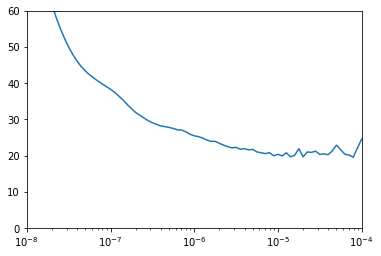

In [25]:

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 2s 57ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 2s 58ms/step - loss: 25.7653 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 2s 59ms/step - loss: 22.0754 - mae: 22.5691
Epoch 4/500
30/30 [==============================] - 2s 54ms/step - loss: 20.4618 - mae: 20.9546
Epoch 5/500
30/30 [==============================] - 2s 55ms/step - loss: 19.7229 - mae: 20.2154
Epoch 6/500
30/30 [==============================] - 2s 55ms/step - loss: 19.3143 - mae: 19.8064
Epoch 7/500
30/30 [==============================] - 2s 56ms/step - loss: 18.6961 - mae: 19.1880
Epoch 8/500
30/30 [==============================] - 2s 57ms/step - loss: 18.1634 - mae: 18.6550
Epoch 9/500
30/30 [==============================] - 2s 59ms/step - loss: 18.1102 - mae: 18.6018
Epoch 10/500
30/30 [==============================] - 2s 54ms/step - loss: 18.6661 - mae: 19.1576
Epoch 11/500
30/30 [=========

30/30 [==============================] - 2s 56ms/step - loss: 16.3749 - mae: 16.8631
Epoch 85/500
30/30 [==============================] - 2s 56ms/step - loss: 16.3969 - mae: 16.8854
Epoch 86/500
30/30 [==============================] - 2s 57ms/step - loss: 16.8046 - mae: 17.2937: 0s - loss: 16.39
Epoch 87/500
30/30 [==============================] - 2s 58ms/step - loss: 16.5575 - mae: 17.0463
Epoch 88/500
30/30 [==============================] - 2s 56ms/step - loss: 16.5257 - mae: 17.0147
Epoch 89/500
30/30 [==============================] - 2s 60ms/step - loss: 16.3482 - mae: 16.8364
Epoch 90/500
30/30 [==============================] - 2s 59ms/step - loss: 16.4305 - mae: 16.9192
Epoch 91/500
30/30 [==============================] - 2s 69ms/step - loss: 16.4311 - mae: 16.9199
Epoch 92/500
30/30 [==============================] - 2s 57ms/step - loss: 16.4774 - mae: 16.9659
Epoch 93/500
30/30 [==============================] - 2s 60ms/step - loss: 16.4578 - mae: 16.9469
Epoch 94/500
30

30/30 [==============================] - 2s 57ms/step - loss: 15.9717 - mae: 16.4600
Epoch 167/500
30/30 [==============================] - 2s 58ms/step - loss: 15.9908 - mae: 16.4793
Epoch 168/500
30/30 [==============================] - 2s 60ms/step - loss: 16.0250 - mae: 16.5137
Epoch 169/500
30/30 [==============================] - 2s 60ms/step - loss: 15.8846 - mae: 16.3728
Epoch 170/500
30/30 [==============================] - 2s 56ms/step - loss: 15.9397 - mae: 16.4280
Epoch 171/500
30/30 [==============================] - 2s 64ms/step - loss: 15.8986 - mae: 16.3868
Epoch 172/500
30/30 [==============================] - 2s 60ms/step - loss: 15.9155 - mae: 16.4037: 1s - los
Epoch 173/500
30/30 [==============================] - 2s 65ms/step - loss: 15.8905 - mae: 16.3788: 1s - loss: 1
Epoch 174/500
30/30 [==============================] - 2s 65ms/step - loss: 16.1238 - mae: 16.6123
Epoch 175/500
30/30 [==============================] - 2s 65ms/step - loss: 16.1025 - mae: 16.5911


30/30 [==============================] - 2s 55ms/step - loss: 15.5021 - mae: 15.9898
Epoch 247/500
30/30 [==============================] - 2s 56ms/step - loss: 15.5244 - mae: 16.0123
Epoch 248/500
30/30 [==============================] - 2s 55ms/step - loss: 15.6611 - mae: 16.1493
Epoch 249/500
30/30 [==============================] - 2s 56ms/step - loss: 16.1111 - mae: 16.5999
Epoch 250/500
30/30 [==============================] - 2s 55ms/step - loss: 15.5695 - mae: 16.0576
Epoch 251/500
30/30 [==============================] - 2s 55ms/step - loss: 15.5111 - mae: 15.9987
Epoch 252/500
30/30 [==============================] - 2s 55ms/step - loss: 15.6072 - mae: 16.0953
Epoch 253/500
30/30 [==============================] - 2s 55ms/step - loss: 15.4618 - mae: 15.9492
Epoch 254/500
30/30 [==============================] - 2s 55ms/step - loss: 15.4859 - mae: 15.9736
Epoch 255/500
30/30 [==============================] - 2s 55ms/step - loss: 15.4847 - mae: 15.9723
Epoch 256/500
30/30 [===

30/30 [==============================] - 2s 55ms/step - loss: 15.1873 - mae: 15.6739
Epoch 329/500
30/30 [==============================] - 2s 54ms/step - loss: 15.2600 - mae: 15.7468
Epoch 330/500
30/30 [==============================] - 2s 55ms/step - loss: 15.2507 - mae: 15.7373
Epoch 331/500
30/30 [==============================] - 2s 55ms/step - loss: 15.1643 - mae: 15.6507
Epoch 332/500
30/30 [==============================] - 2s 55ms/step - loss: 15.1266 - mae: 15.6127
Epoch 333/500
30/30 [==============================] - 2s 55ms/step - loss: 15.1548 - mae: 15.6410
Epoch 334/500
30/30 [==============================] - 2s 55ms/step - loss: 15.2644 - mae: 15.7510
Epoch 335/500
30/30 [==============================] - 2s 55ms/step - loss: 15.1300 - mae: 15.6162
Epoch 336/500
30/30 [==============================] - 2s 55ms/step - loss: 15.0982 - mae: 15.5847
Epoch 337/500
30/30 [==============================] - 2s 54ms/step - loss: 15.1084 - mae: 15.5948
Epoch 338/500
30/30 [===

30/30 [==============================] - 2s 55ms/step - loss: 14.9203 - mae: 15.4062
Epoch 411/500
30/30 [==============================] - 2s 54ms/step - loss: 14.9289 - mae: 15.4149
Epoch 412/500
30/30 [==============================] - 2s 55ms/step - loss: 14.7896 - mae: 15.2749
Epoch 413/500
30/30 [==============================] - 2s 55ms/step - loss: 14.7530 - mae: 15.2382
Epoch 414/500
30/30 [==============================] - 2s 54ms/step - loss: 14.8664 - mae: 15.3520
Epoch 415/500
30/30 [==============================] - 2s 55ms/step - loss: 14.8951 - mae: 15.3814
Epoch 416/500
30/30 [==============================] - 2s 55ms/step - loss: 15.1437 - mae: 15.6304
Epoch 417/500
30/30 [==============================] - 2s 55ms/step - loss: 14.8622 - mae: 15.3482
Epoch 418/500
30/30 [==============================] - 2s 55ms/step - loss: 14.8766 - mae: 15.3627
Epoch 419/500
30/30 [==============================] - 2s 55ms/step - loss: 14.7444 - mae: 15.2298
Epoch 420/500
30/30 [===

30/30 [==============================] - 2s 56ms/step - loss: 14.5932 - mae: 15.0790
Epoch 493/500
30/30 [==============================] - 2s 54ms/step - loss: 14.4961 - mae: 14.9812
Epoch 494/500
30/30 [==============================] - 2s 55ms/step - loss: 14.4690 - mae: 14.9542
Epoch 495/500
30/30 [==============================] - 2s 54ms/step - loss: 14.5400 - mae: 15.0255
Epoch 496/500
30/30 [==============================] - 2s 55ms/step - loss: 14.4825 - mae: 14.9679
Epoch 497/500
30/30 [==============================] - 2s 54ms/step - loss: 14.6181 - mae: 15.1040
Epoch 498/500
30/30 [==============================] - 2s 55ms/step - loss: 14.6525 - mae: 15.1384
Epoch 499/500
30/30 [==============================] - 2s 55ms/step - loss: 14.4904 - mae: 14.9761
Epoch 500/500
30/30 [==============================] - 2s 56ms/step - loss: 14.5598 - mae: 15.0455


In [31]:

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)




In [32]:
rnn_forecast.shape

(3172, 64, 1)

In [ ]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

<Figure size 432x288 with 0 Axes>

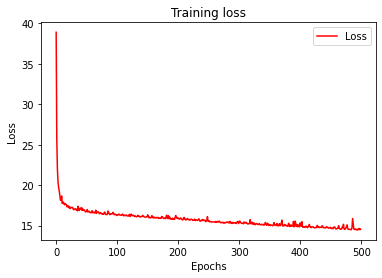

<Figure size 432x288 with 0 Axes>

In [28]:

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

<Figure size 432x288 with 0 Axes>

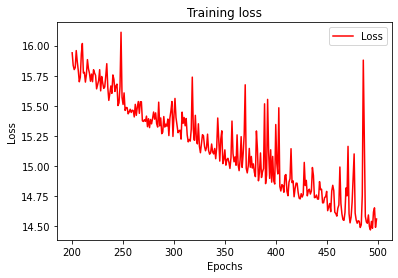

<Figure size 432x288 with 0 Axes>

In [29]:

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



In [30]:
print(rnn_forecast)

[135.95099   103.802505  111.07127   132.00092   112.73032   147.87161
 191.4422    170.13263   192.44716   153.74443   161.60783   177.08986
 166.96535   168.7135    197.78392   181.12991   185.7131    191.56067
 183.82932   195.7202    192.81598   181.49834   183.3802    185.35835
 152.60048   138.54367   137.59753   153.19066   146.16666   130.38147
 184.87952   121.47594   126.06955   212.32927   175.80537   181.0026
 186.36346   152.21667   148.01959   151.15523   160.4824    164.8295
 146.41765   148.63219   175.69342   155.98984   149.94061   138.83119
 132.34271   130.7298    104.594444  110.2826    105.43289    95.39729
 111.14013   107.82859    98.62037    83.56896    82.65701    76.854416
  71.722176   72.87988    75.92587    83.10631    71.08586    70.56118
  69.54992    75.50428    75.81661    53.929455   63.87311    74.13791
  47.372524   44.820984   46.87675    37.05539    35.50421    43.659927
  43.759464   44.52799    53.17691    35.82857    28.672379   26.108604
  44.